In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv('data/okcupid_preprocessed.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   orientation                 59934 non-null  int64  
 3   drugs                       59934 non-null  int64  
 4   education                   53310 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   sign                        59934 non-null  int64  
 9   age                         59934 non-null  int64  
 10  status                      59934 non-null  object 
 11  diet                        35547 non-null  object 
 12  location                    59934 non-null  object 
 13  pets                        400

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

X = df[['sex', 'orientation', 'body_type_average', 'body_type_curvy', 'body_type_fit', 
        'body_type_slim', 'drinks_heavy','drinks_moderate', 'drinks_no_drinks',
        'drugs', 'education', 'height', 'job_encoding', 'smokes_smoke', 'smokes_sometime_smoke', 'age', 'status_encoding']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65      7140
           1       0.45      0.38      0.41      4847

    accuracy                           0.56     11987
   macro avg       0.54      0.53      0.53     11987
weighted avg       0.55      0.56      0.56     11987



In [10]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_searchcv = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
)
grid_searchcv.fit(X_train, y_train)
print("Best Hyperparameters:", grid_searchcv.best_params_)

c:\Users\Playdata\miniconda3\envs\mlstudy_env\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [11]:
best_rf = grid_searchcv.best_estimator_
y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import classification_report
print("\n[튜닝 후 Classification Report]")
print(classification_report(y_test, y_pred_best))


[튜닝 후 Classification Report]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      7140
           1       0.49      0.49      0.49      4847

    accuracy                           0.59     11987
   macro avg       0.58      0.57      0.58     11987
weighted avg       0.59      0.59      0.59     11987



In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("\n[최종 모델 Classification Report]")
print(classification_report(y_test, y_pred_best))

Cross-validation scores: [0.48581837 0.48128762 0.49119555 0.48770332 0.48262346]
Mean CV score: 0.48572566530992456

[최종 모델 Classification Report]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      7140
           1       0.49      0.49      0.49      4847

    accuracy                           0.59     11987
   macro avg       0.58      0.57      0.58     11987
weighted avg       0.59      0.59      0.59     11987



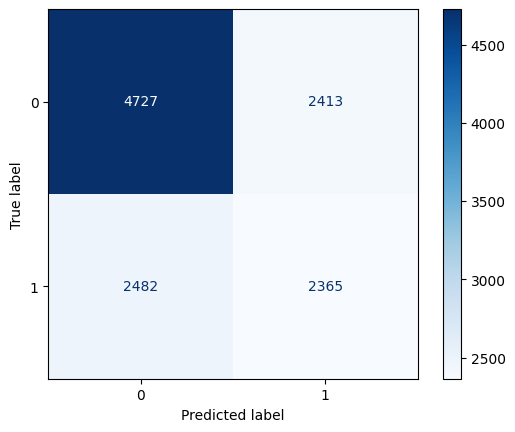

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

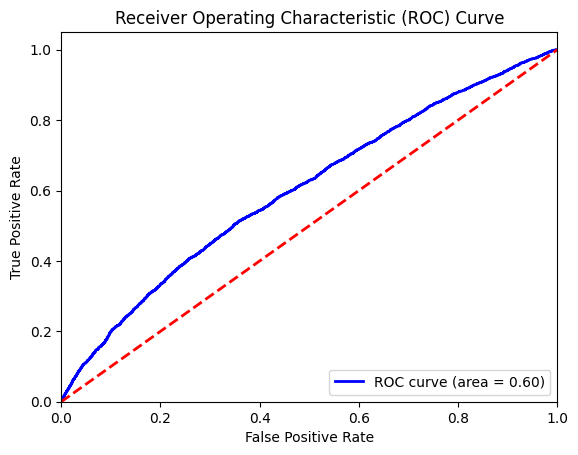

In [14]:
# ROC곡선
from sklearn.metrics import roc_curve, auc
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

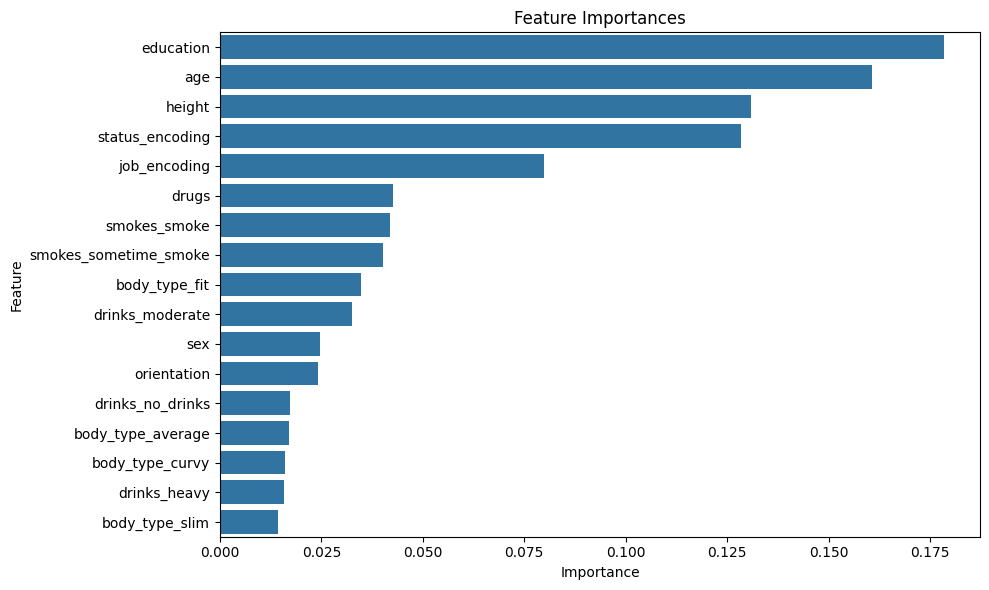

In [15]:
# 특성 중요도
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
# optuna
import optuna

def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced'])
    }
    rf_model = RandomForestClassifier(random_state=42, **param_grid)
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    return cv_scores.mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2026-02-23 16:09:18,810] A new study created in memory with name: no-name-fb8655f4-8c91-4881-902c-db341bc5a5e8
[I 2026-02-23 16:09:27,937] Trial 0 finished with value: 0.4571406511691031 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4571406511691031.
[I 2026-02-23 16:09:35,427] Trial 1 finished with value: 0.4538304185493483 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4571406511691031.
[I 2026-02-23 16:09:44,641] Trial 2 finished with value: 0.41543821928272007 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4571406511691031.
[I 2026-02-23 16:09:51,396] Trial 3 finished with value: 0.48194167807932964 and parameters: {'n_estimators': 300, 'max

In [ ]:
print("Best Hyperparameters:", study.best_params_)
best_rf_optuna = RandomForestClassifier(random_state=42, **study.best_params_)
best_rf_optuna.fit(X_train, y_train)

AttributeError: 'Study' object has no attribute 'best_params_'

In [ ]:
df['body_type_average'].value_counts(), df['body_type_curvy'].value_counts(), df['body_type_fit'].value_counts(), df['body_type_slim'].value_counts()


(body_type_average
 False    45282
 True     14652
 Name: count, dtype: int64,
 body_type_curvy
 False    51928
 True      8006
 Name: count, dtype: int64,
 body_type_fit
 False    34986
 True     24948
 Name: count, dtype: int64,
 body_type_slim
 False    53447
 True      6487
 Name: count, dtype: int64)